In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Number of pictures in the dataset: 60202

Number of different labels: 28

Labels: ['M' 'Z' 'I' 'G' 'D' 'B' 'H' 'A' 'F' 'O' 'W' 'R' 'Q' 'K' 'space' 'E' 'U'
 'C' 'T' 'nothing' 'J' 'S' 'X' 'V' 'P' 'Y' 'L' 'N']


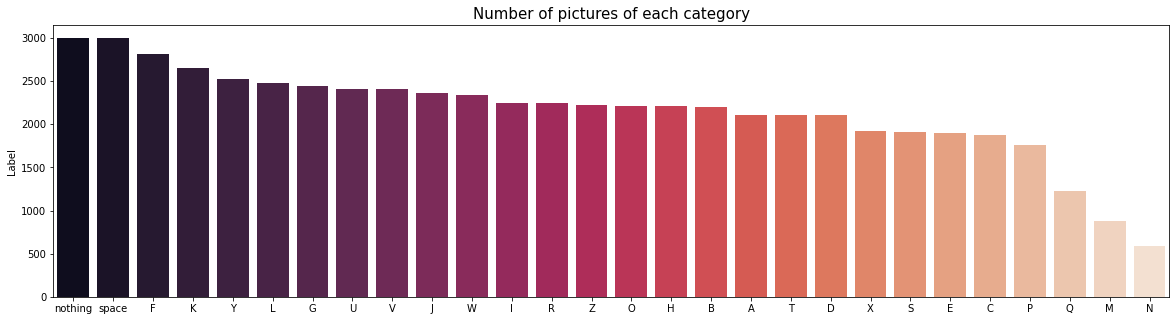

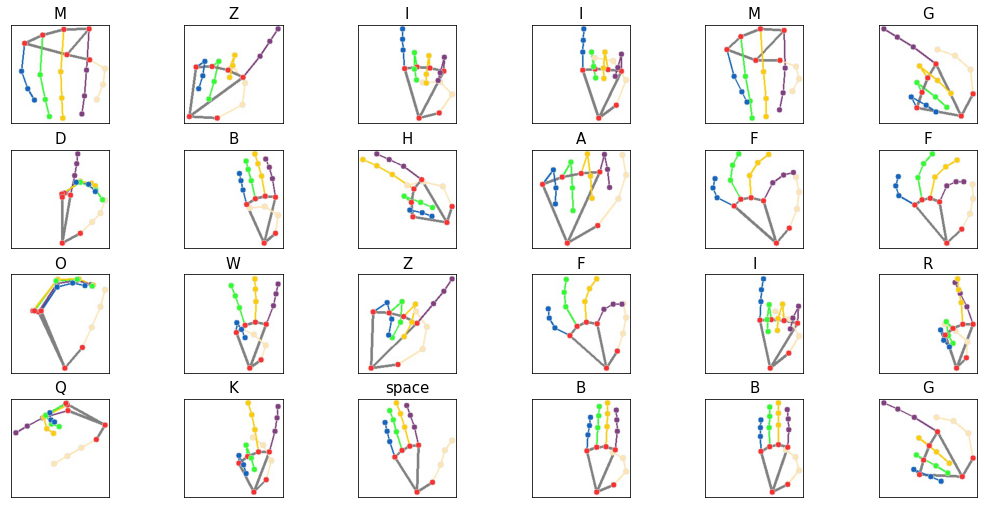

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from time import perf_counter
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from IPython.display import Markdown, display


def printmd(string):
    # Print with Markdowns
    display(Markdown(string))


dir_ = Path('drive/My Drive/SKELETONS')
file_paths = list(dir_.glob(r'**/*.jpg'))


def proc_img(filepath):
    #Create a DataFrame with the filepath and the labels of the pictures
    labels = [str(filepath[i]).split("/")[-2] for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1, random_state=0).reset_index(drop=True)

    return df


df = proc_img(file_paths)

print(f'Number of pictures in the dataset: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}')

# The DataFrame with the filepaths in one column and the labels in the other one
df.head(5)

# Display the number of pictures of each category
vc = df['Label'].value_counts()
plt.figure(figsize=(20, 5))
sns.barplot(x=vc.index, y=vc, palette="rocket")
plt.title("Number of pictures of each category", fontsize=15)
plt.show()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(15, 7),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Label[i], fontsize=15)
plt.tight_layout(pad=0.5)
plt.show()

# Use 5% of the dataset for testing various models
# Split into training and test datasets
train_df, test_df = train_test_split(df.sample(frac=0.05), test_size=0.2, random_state=0)


def create_gen():
    # Load the Images with a generator and Data Augmentation
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(192, 192),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=256,
        shuffle=True,
        seed=0,
        subset='training'
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(192, 192),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=256,
        shuffle=True,
        seed=0,
        subset='validation'
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(192, 192),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=256,
        shuffle=False
    )

    return train_generator, test_generator, train_images, val_images, test_images


def get_model(model):
    # Load the pretained model
    kwargs = {'input_shape': (192, 192, 3),
              'include_top': False,
              'weights': 'imagenet',
              'pooling': 'avg'}

    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False

    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(28, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


# Dictionary with the models
models = {
    #"DenseNet121": {"model": tf.keras.applications.DenseNet121, "perf": 0},
    #"DenseNet169": {"model": tf.keras.applications.DenseNet169, "perf": 0},
    #"DenseNet201": {"model": tf.keras.applications.DenseNet201, "perf": 0},
    #"InceptionResNetV2": {"model": tf.keras.applications.InceptionResNetV2, "perf": 0},
    #"InceptionV3": {"model": tf.keras.applications.InceptionV3, "perf": 0},
    "MobileNet": {"model": tf.keras.applications.MobileNet, "perf": 0},
    "MobileNetV2": {"model": tf.keras.applications.MobileNetV2, "perf": 0},
    #"MobileNetV3Large": {"model": tf.keras.applications.MobileNetV3Large, "perf": 0},
    #"MobileNetV3Small": {"model": tf.keras.applications.MobileNetV3Small, "perf": 0},
    #"NASNetMobile": {"model": tf.keras.applications.NASNetMobile, "perf": 0},
    #"ResNet101": {"model": tf.keras.applications.ResNet101, "perf": 0},
    "ResNet101V2": {"model": tf.keras.applications.ResNet101V2, "perf": 0},
    #"ResNet152": {"model": tf.keras.applications.ResNet152, "perf": 0},
    "ResNet152V2": {"model": tf.keras.applications.ResNet152V2, "perf": 0},
    #"ResNet50": {"model": tf.keras.applications.ResNet50, "perf": 0},
    #"ResNet50V2": {"model": tf.keras.applications.ResNet50V2, "perf": 0},
    #"VGG16": {"model": tf.keras.applications.VGG16, "perf": 0},
    #"VGG19": {"model": tf.keras.applications.VGG19, "perf": 0},
    #"Xception": {"model": tf.keras.applications.Xception, "perf": 0}
}


Found 2168 validated image filenames belonging to 28 classes.
Found 240 validated image filenames belonging to 28 classes.
Found 602 validated image filenames belonging to 28 classes.


9420800/9406464 [==============================] - 0s 0us/step
MobileNetV2          trained in 574.8 sec
51888128/51877672 [==============================] - 0s 0us/step
DenseNet169          trained in 50.56 sec
17235968/17225924 [==============================] - 0s 0us/step
"EfficientNetB0": {"model": tf.keras.applications.EfficientNetB0, "perf": 0},
    "EfficientNetB1": {"model": tf.keras.applications.EfficientNetB1, "perf": 0},
    "EfficientNetB2": {"model": tf.keras.applications.EfficientNetB2, "perf": 0},
    "EfficientNetB3": {"model": tf.keras.applications.EfficientNetB3, "perf": 0},
    "EfficientNetB4": {"model": tf.keras.applications.EfficientNetB4, "perf": 0},
    "EfficientNetB5": {"model": tf.keras.applications.EfficientNetB4, "perf": 0},
    "EfficientNetB6": {"model": tf.keras.applicat

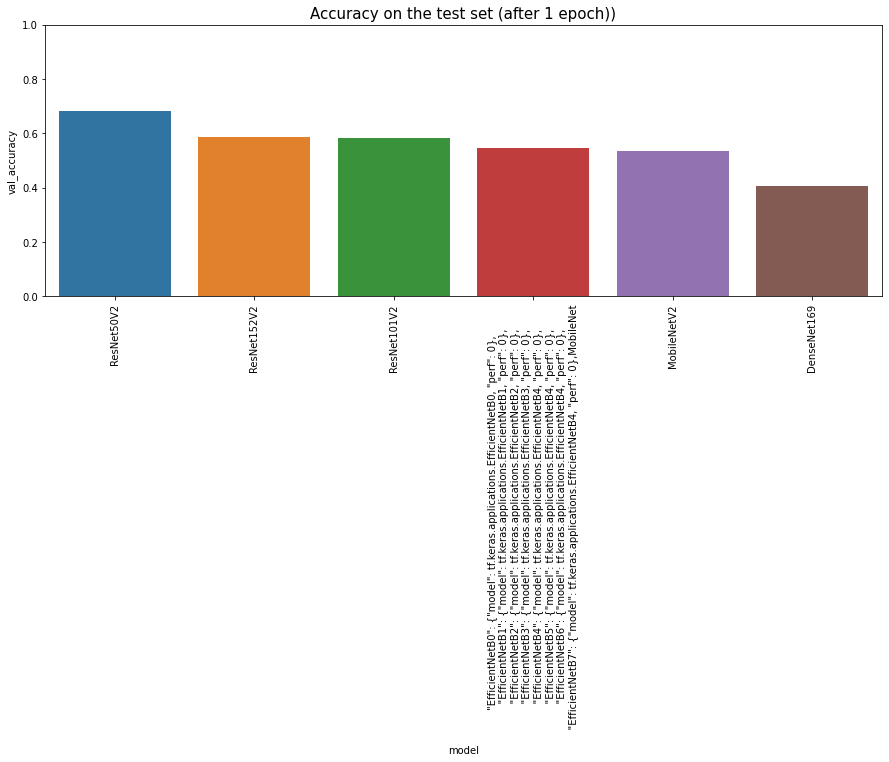

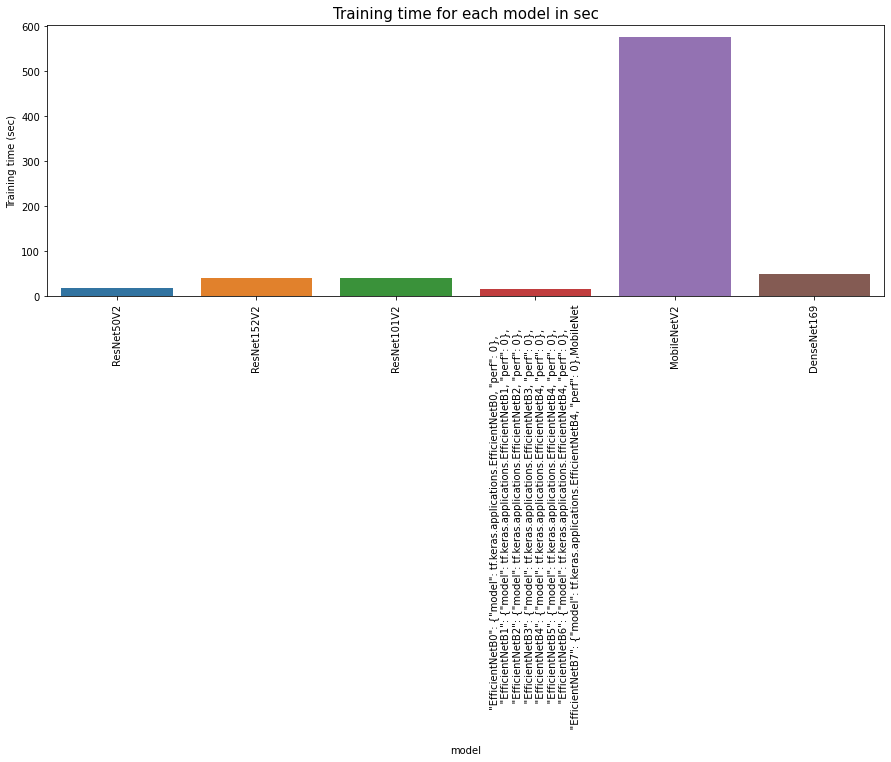

In [ ]:
# Create the generators
train_generator, test_generator, train_images, val_images, test_images = create_gen()
print('\n')

# Fit the models
for name, model in models.items():
    # Get the model
    m = get_model(model['model'])
    models[name]['model'] = m

    start = perf_counter()

    # Fit the model
    history = m.fit(train_images, validation_data=val_images, epochs=1, verbose=0)

    # Save the duration and the val_accuracy
    duration = perf_counter() - start
    duration = round(duration, 2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")

    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v, 4) for v in val_acc]

# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([name, models[name]['val_acc'][-1],
                          models[name]['perf']])

df_results = pd.DataFrame(models_result,
                          columns=['model', 'val_accuracy', 'Training time (sec)'])
df_results.sort_values(by='val_accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True, drop=True)
print(df_results)

plt.figure(figsize=(15, 5))
sns.barplot(x='model', y='val_accuracy', data=df_results)
plt.title('Accuracy on the test set (after 1 epoch))', fontsize=15)
plt.ylim(0, 1)
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(15, 5))
sns.barplot(x='model', y='Training time (sec)', data=df_results)
plt.title('Training time for each model in sec', fontsize=15)
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Use the whole data which is split into training and test datasets
train_df, test_df = train_test_split(df, test_size=0.1, random_state=0)

# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()

# Get the model with the highest validation score
#best_model = df_results.iloc[3]

# Create a new model
model = get_model( eval("tf.keras.applications.MobileNetV2") )

# Train the model
history = model.fit(train_images,
                    validation_data=val_images,
                    epochs=19,
                    callbacks=[
                        tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            patience=3,
                            restore_best_weights=True)]
                    )

Found 48763 validated image filenames belonging to 28 classes.
Found 5418 validated image filenames belonging to 28 classes.
Found 6021 validated image filenames belonging to 28 classes.
17235968/17225924 [==============================] - 0s 0us/step
Epoch 1/19
191/191 [==============================] - 9681s 51s/step - loss: 0.3087 - accuracy: 0.9348 - val_loss: 0.0239 - val_accuracy: 0.9965
Epoch 2/19
191/191 [==============================] - 164s 857ms/step - loss: 0.0184 - accuracy: 0.9963 - val_loss: 0.0104 - val_accuracy: 0.9983
Epoch 3/19
191/191 [==============================] - 164s 855ms/step - loss: 0.0096 - accuracy: 0.9978 - val_loss: 0.0106 - val_accuracy: 0.9967
Epoch 4/19
191/191 [==============================] - 164s 856ms/step - loss: 0.0070 - accuracy: 0.9985 - val_loss: 0.0072 - val_accuracy: 0.9985
Epoch 5/19
191/191 [==============================] - 165s 861ms/step - loss: 0.0051 - accuracy: 0.9989 - val_loss: 0.0061 - val_accuracy: 0.9983
Epoch 6/19
191/191 

In [ ]:
# Use the whole data which is split into training and test datasets
train_df, test_df = train_test_split(df, test_size=0.1, random_state=0)

# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()

# Get the model with the highest validation score
#best_model = df_results.iloc[3]

# Create a new model
model = get_model( eval("tf.keras.applications.MobileNetV2") )

# Train the model
history = model.fit(train_images,
                    validation_data=val_images,
                    epochs=13,
                    callbacks=[
                        tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            patience=3,
                            restore_best_weights=True)]
                    )

Found 48763 validated image filenames belonging to 28 classes.
Found 5418 validated image filenames belonging to 28 classes.
Found 6021 validated image filenames belonging to 28 classes.
9420800/9406464 [==============================] - 0s 0us/step
Epoch 1/13
191/191 [==============================] - 172s 871ms/step - loss: 0.3193 - accuracy: 0.9323 - val_loss: 0.0399 - val_accuracy: 0.9893
Epoch 2/13
191/191 [==============================] - 162s 847ms/step - loss: 0.0238 - accuracy: 0.9942 - val_loss: 0.0235 - val_accuracy: 0.9928
Epoch 3/13
191/191 [==============================] - 163s 851ms/step - loss: 0.0118 - accuracy: 0.9973 - val_loss: 0.0113 - val_accuracy: 0.9980
Epoch 4/13
191/191 [==============================] - 165s 861ms/step - loss: 0.0078 - accuracy: 0.9983 - val_loss: 0.0113 - val_accuracy: 0.9970
Epoch 5/13
191/191 [==============================] - 163s 854ms/step - loss: 0.0054 - accuracy: 0.9988 - val_loss: 0.0129 - val_accuracy: 0.9969
Epoch 6/13
191/191 [

INFO:tensorflow:Assets written to: drive/My Drive/gr_mobilenetV2_model/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


## Best Model: MobileNetV2 with 99.78% accuracy on the test set

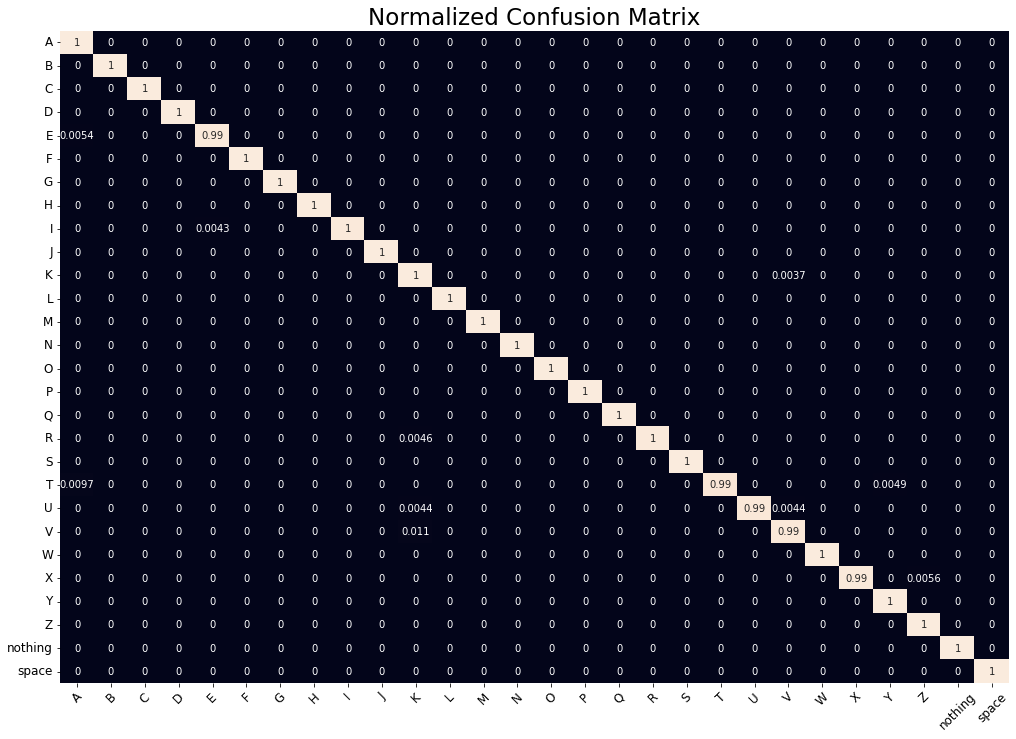

In [ ]:
model.save('drive/My Drive/gr_mobilenetV2_model')

# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Get the accuracy on the test set
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)

# Display the results
printmd(f'## Best Model: MobileNetV2 with {acc*100:.2f}% accuracy on the test set')

# Display a confusion matrix
cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (17,12))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=False)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=12,rotation=45)
plt.yticks(fontsize=12)
plt.show()

## Best Model: MobileNet with 99.92% accuracy on the test set

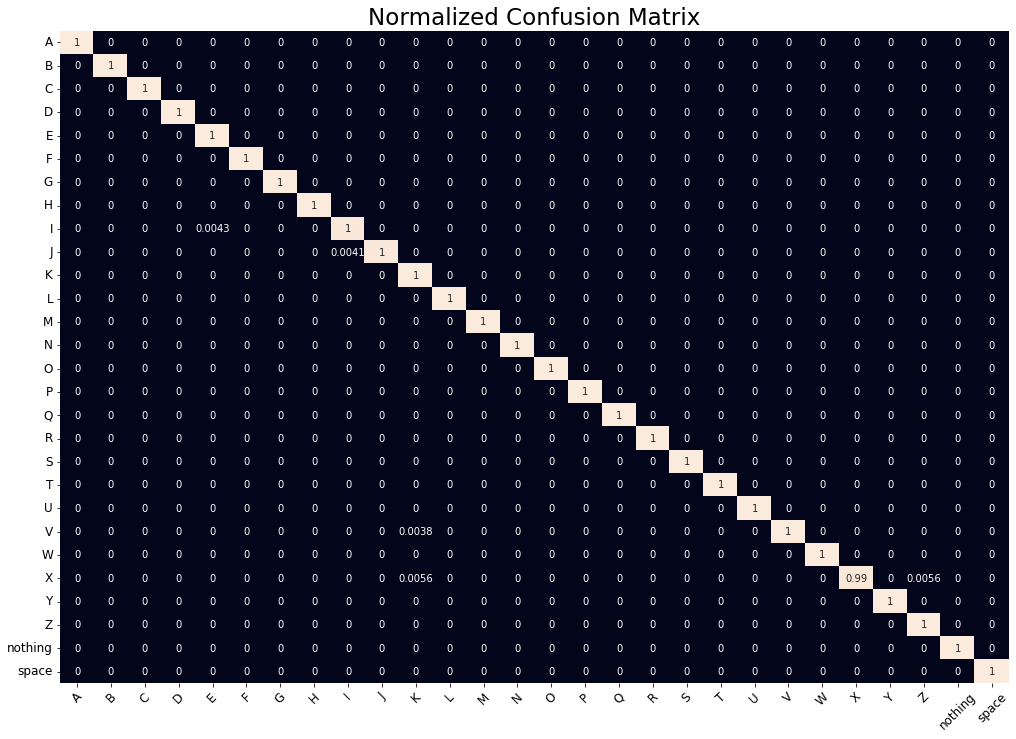

In [ ]:
# Display the results
printmd(f'## Best Model: MobileNet with {acc*100:.2f}% accuracy on the test set')

# Display a confusion matrix
cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (17,12))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=False)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=12,rotation=45)
plt.yticks(fontsize=12)
plt.show()

In [ ]:
pip install keras-tuner

     |████████████████████████████████| 98 kB 3.7 MB/s 


Создание CNN моделей

In [ ]:
import numpy as np
from pandas import read_csv
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from keras.layers.merge import concatenate
from keras.layers import add
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from kerastuner.tuners import BayesianOptimization
from kerastuner import HyperParameters
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from imutils import paths
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.


In [ ]:
train_generator, test_generator, train_images, val_images, test_images = create_gen()

Found 2168 validated image filenames belonging to 28 classes.
Found 240 validated image filenames belonging to 28 classes.
Found 602 validated image filenames belonging to 28 classes.


In [ ]:
def modelCNN(hp):
    model = Sequential()
    activation_choice = hp.Choice('activation', values=['relu', 'elu', 'selu'])
    ks1=hp.Int('kernel_size_1', 3, 6)
    mp1=hp.Int('pool_size_1', 2, 3)
    ki1=hp.Choice('kernel_initializer', values=['he_uniform', 'he_normal', 'glorot_uniform', 'glorot_normal', 'orthogonal'])
    model.add(Conv2D(hp.Int('conv2d_1', min_value=32, max_value=128,step=32), (ks1, ks1), activation=activation_choice, padding='same', 
                 input_shape=(192, 192, 3), kernel_initializer=ki1))
    for j in range(hp.Int('num_cycles', 2, 4)):
      k=hp.Int('num_conv'+str(j), 1, 3)
      for i in range(k):
        model.add(Conv2D(hp.Int('conv2d_'+str(j+1)+'_'+str(i+1), min_value=32, max_value=128,step=32), (ks1, ks1), activation=activation_choice, padding='same', kernel_initializer=ki1))
      model.add(MaxPooling2D((mp1, mp1), strides=hp.Int('maxpool_strides', 1, 3)))
      
    model.add(Flatten())
    model.add(Dropout(hp.Float('dropout_coef', min_value=0.05, max_value=0.9, step=0.1)))

    '''for j in range(hp.Int('num_denses', 0, 3)):
        model.add(Dense(units=hp.Int('dense_' + str(j), min_value=32, max_value=512,step=32), activation=activation_choice))
        model.add(Dropout(hp.Float('dropout_coef', min_value=0.05, max_value=0.9, step=0.1)))'''
    
    model.add(Dense(28, activation=hp.Choice('activation_last', values=['softmax'])))
    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam','rmsprop','SGD']),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model

In [ ]:
hp1 = HyperParameters()

tuner1 = BayesianOptimization(
    modelCNN,
    hyperparameters=hp1,
    objective='val_accuracy',
    max_trials=8,             
    directory='congr'
    )
tuner1.search_space_summary()

Search space summary
Default search space size: 14
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'elu', 'selu'], 'ordered': False}
kernel_size_1 (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 6, 'step': 1, 'sampling': None}
pool_size_1 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 3, 'step': 1, 'sampling': None}
kernel_initializer (Choice)
{'default': 'he_uniform', 'conditions': [], 'values': ['he_uniform', 'he_normal', 'glorot_uniform', 'glorot_normal', 'orthogonal'], 'ordered': False}
conv2d_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': None}
num_cycles (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 4, 'step': 1, 'sampling': None}
num_conv0 (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
conv2d_1_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 12

In [ ]:
tuner1.search(train_images,
             epochs=4,
             validation_data = val_images,
             #callbacks=[ReduceLROnPlateau(monitor='accuracy', patience=5, factor=0.2, min_lr=0.001)]
             )

tuner1.results_summary()

Trial 8 Complete [00h 09m 19s]
val_accuracy: 0.9458333253860474

Best val_accuracy So Far: 0.9624999761581421
Total elapsed time: 00h 32m 11s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in congr/untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
activation: selu
kernel_size_1: 3
pool_size_1: 3
kernel_initializer: glorot_normal
conv2d_1: 32
num_cycles: 4
num_conv0: 1
conv2d_1_1: 96
maxpool_strides: 2
num_conv1: 1
conv2d_2_1: 32
dropout_coef: 0.8500000000000002
activation_last: softmax
optimizer: adam
conv2d_1_2: 96
conv2d_2_2: 128
conv2d_2_3: 32
num_conv2: 2
conv2d_3_1: 128
num_conv3: 1
conv2d_4_1: 128
conv2d_3_2: 96
Score: 0.9624999761581421
Trial summary
Hyperparameters:
activation: selu
kernel_size_1: 3
pool_size_1: 3
kernel_initializer: orthogonal
conv2d_1: 32
num_cycles: 2
num_conv0: 1
conv2d_1_1: 64
maxpool_strides: 1
num_conv1: 1
conv2d_2_1: 32
dropout_coef: 0.8500000000000002
activation_last: s

In [ ]:
#models1 = tuner1.get_best_models(num_models=3)
results = []
for model in models1:
  model.summary()
  res=model.fit(train_images, validation_data=val_images, epochs=6, shuffle = True, callbacks=[ReduceLROnPlateau(monitor='accuracy', patience=5, factor=0.2, min_lr=0.001)])
  results.append(res)
  _, accuracy = model.evaluate(test_images)
  model.evaluate(test_images)
  print()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 192, 192, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 192, 192, 96)      27744     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 95, 95, 96)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 95, 95, 32)        27680     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 47, 47, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 47, 47, 128)       3

In [ ]:
i = 0
for model in models1:
  i = i + 1
  model.summary()
  _, accuracy = model.evaluate(test_images)
  print()
  model.save('drive/My Drive/gr_' + str(i) + '_model')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 192, 192, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 192, 192, 96)      27744     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 95, 95, 96)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 95, 95, 32)        27680     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 47, 47, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 47, 47, 128)       3

In [ ]:
for model in models1:
  model.summary()
  model.fit(train_images, validation_data=val_images, epochs=4, shuffle = True, callbacks=[ReduceLROnPlateau(monitor='accuracy', patience=5, factor=0.2, min_lr=0.001)])
  results.append(res)
  _, accuracy = model.evaluate(test_images)
  print()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 192, 192, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 192, 192, 96)      27744     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 95, 95, 96)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 95, 95, 32)        27680     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 47, 47, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 47, 47, 128)       3

In [ ]:
i = 0
for model in models1:
  i = i + 1
  model.summary()
  _, accuracy = model.evaluate(test_images)
  print()
  model.save('drive/My Drive/gr_0' + str(i) + '_model')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 192, 192, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 192, 192, 96)      27744     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 95, 95, 96)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 95, 95, 32)        27680     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 47, 47, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 47, 47, 128)       3

In [ ]:
epochs, batch_size = 15, 64
n_timesteps, n_features, n_outputs = x_train.shape[1], x_train.shape[2], y_train.shape[1]
model8 = Sequential()
model8.add(Bidirectional(GRU(384, return_sequences=True), input_shape=(n_timesteps,n_features)))
model8.add(Dropout(0.05))
model8.add(Bidirectional(GRU(384)))
model8.add(Dropout(0.05))
model8.add(Dense(576, activation='relu'))
model8.add(Dropout(0.05))
model8.add(Dense(n_outputs, activation='softmax'))
model8.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
loss8 = model8.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[ReduceLROnPlateau(monitor='accuracy', patience=4, factor=0.2, min_lr=0.001)])
_, accuracy = model8.evaluate(x_test, y_test, batch_size=batch_size)
model8.summary()
print('Accuracy: %.5f' % accuracy)

In [ ]:
i = 0
for model in models1:
  i = i + 1
  model.summary()
  _, accuracy = model.evaluate(test_images)
  print()
  model.save('drive/My Drive/gr_' + i + '_model')

NameError: ignored